# Power-of-Two Quantization Proof

bfloat16 values are discrete bit patterns. Any separation between bfloat16 values must be a power-of-two multiple of the fundamental quantum (smallest ULP in range).

Strategy:
- For each dimension, compute all adjacent separations
- Find the minimum separation (fundamental quantum)
- Show that ALL separations = quantum × 2^n for integer n
- If true → ironclad proof of bfloat16 quantization

This should resolve the 0.5 fractional error mystery from 1.11f.

## Parameters

In [66]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Analysis
POWER_OF_TWO_TOLERANCE = 1e-12  # Tolerance for exact power of 2
SHOW_TOP_N_DIMENSIONS = 10      # Show detailed results for N most diverse dimensions

## Imports

In [67]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt

## Device Detection

In [68]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [69]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f'Loaded {len(cluster_token_ids)} cluster token IDs')

Loaded 2212 cluster token IDs


In [70]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f'Loaded gamma matrix: {W.shape}')
print(f'Precision: {W.dtype}')

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [71]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f'Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}')

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors

In [72]:
# Find unique vectors (stay in bfloat16)
unique_vectors = torch.unique(cluster_vectors.to('cpu'), dim=0).to(device)

print(f'Found {len(unique_vectors)} unique vectors')
print(f'Precision: {unique_vectors.dtype}')

Found 125 unique vectors
Precision: torch.bfloat16


## Power-of-Two Analysis Function

In [73]:
def is_power_of_two_multiple(value, quantum, tolerance=1e-12):
    """
    Check if value = quantum * 2^n for some integer n.
    
    Returns (is_power_of_two, exponent, error)
    """
    if quantum == 0 or value == 0:
        return False, None, None
    
    # Compute ratio
    ratio = value / quantum
    
    # If ratio is a power of 2, then log2(ratio) should be an integer
    log2_ratio = np.log2(ratio)
    
    # Round to nearest integer
    n = round(log2_ratio)
    
    # Check if 2^n * quantum approx equals value
    expected = quantum * (2 ** n)
    error = abs(expected - value) / value
    
    is_power = error < tolerance
    
    return is_power, n, error

# Test
quantum = 1e-9
test_values = [quantum, 2*quantum, 4*quantum, 8*quantum, 3*quantum]
for val in test_values:
    is_pow2, n, err = is_power_of_two_multiple(val, quantum)
    print(f'{val:.2e}: power_of_2={is_pow2}, n={n}, error={err:.2e}')

1.00e-09: power_of_2=True, n=0, error=0.00e+00
2.00e-09: power_of_2=True, n=1, error=0.00e+00
4.00e-09: power_of_2=True, n=2, error=0.00e+00
8.00e-09: power_of_2=True, n=3, error=0.00e+00
3.00e-09: power_of_2=False, n=2, error=3.33e-01


## Analyze Each Dimension

In [74]:
# Convert to float32 for analysis
vectors_f32 = unique_vectors.to(torch.float32).cpu().numpy()

num_dims = vectors_f32.shape[1]

# Storage for results
dimension_stats = []

# For each dimension
for dim_idx in range(num_dims):
    # Get unique values in this dimension
    values = np.unique(vectors_f32[:, dim_idx])
    n_unique = len(values)
    
    if n_unique <= 1:
        # Constant dimension - skip
        continue
    
    # Sort values
    values_sorted = np.sort(values)
    
    # Compute all separations
    separations = []
    for i in range(len(values_sorted) - 1):
        sep = values_sorted[i + 1] - values_sorted[i]
        separations.append(sep)
    
    separations = np.array(separations)
    
    # Find minimum separation (fundamental quantum for this dimension)
    quantum = separations.min()
    
    # Check if all separations are power-of-2 multiples of quantum
    power_of_two_results = []
    exponents = []
    errors = []
    
    for sep in separations:
        is_pow2, n, err = is_power_of_two_multiple(sep, quantum, POWER_OF_TWO_TOLERANCE)
        power_of_two_results.append(is_pow2)
        exponents.append(n)
        errors.append(err)
    
    # Store statistics
    dimension_stats.append({
        'dim_idx': dim_idx,
        'n_unique': n_unique,
        'quantum': quantum,
        'separations': separations,
        'all_power_of_two': all(power_of_two_results),
        'n_power_of_two': sum(power_of_two_results),
        'n_total': len(separations),
        'exponents': exponents,
        'max_error': max(errors) if errors else 0,
        'mean_error': np.mean(errors) if errors else 0,
    })

print(f'Analyzed {len(dimension_stats)} varying dimensions')

Analyzed 2197 varying dimensions


## Global Statistics

In [75]:
# Count dimensions with perfect power-of-two quantization
n_perfect_dims = sum(1 for s in dimension_stats if s['all_power_of_two'])
n_total_dims = len(dimension_stats)

# Count individual separations
n_perfect_seps = sum(s['n_power_of_two'] for s in dimension_stats)
n_total_seps = sum(s['n_total'] for s in dimension_stats)

# Collect all errors
all_errors = [s['max_error'] for s in dimension_stats]
max_error_global = max(all_errors) if all_errors else 0

print('='*70)
print('POWER-OF-TWO QUANTIZATION PROOF')
print('='*70)
print(f'Dimensions analyzed: {n_total_dims}')
print(f'Dimensions with perfect power-of-2 quantization: {n_perfect_dims} '
      f'({100*n_perfect_dims/n_total_dims:.2f}%)')
print()
print(f'Total separations analyzed: {n_total_seps:,}')
print(f'Separations that are power-of-2 multiples: {n_perfect_seps:,} '
      f'({100*n_perfect_seps/n_total_seps:.4f}%)')
print()
print(f'Maximum relative error: {max_error_global:.6e}')
print(f'Tolerance: {POWER_OF_TWO_TOLERANCE:.6e}')
print('='*70)

if n_perfect_dims == n_total_dims:
    print('\n✓ PROOF COMPLETE: All separations are exact power-of-2 multiples')
    print('  This is conclusive proof of bfloat16 quantization')
else:
    print(f'\n⚠ PARTIAL: {n_total_dims - n_perfect_dims} dimensions have non-power-of-2 separations')

POWER-OF-TWO QUANTIZATION PROOF
Dimensions analyzed: 2197
Dimensions with perfect power-of-2 quantization: 1987 (90.44%)

Total separations analyzed: 10,291
Separations that are power-of-2 multiples: 9,467 (91.9930%)

Maximum relative error: 3.913043e-01
Tolerance: 1.000000e-12

⚠ PARTIAL: 210 dimensions have non-power-of-2 separations


## Detailed Results: Most Diverse Dimensions

In [76]:
# Sort by number of unique values (most diverse first)
dimension_stats_sorted = sorted(dimension_stats, key=lambda x: x['n_unique'], reverse=True)

print(f'\nTop {SHOW_TOP_N_DIMENSIONS} most diverse dimensions:')
print('='*70)

for i, stats in enumerate(dimension_stats_sorted[:SHOW_TOP_N_DIMENSIONS]):
    dim_idx = stats['dim_idx']
    n_unique = stats['n_unique']
    quantum = stats['quantum']
    all_pow2 = stats['all_power_of_two']
    
    print(f'\nDimension {dim_idx}:')
    print(f'  Unique values: {n_unique}')
    print(f'  Fundamental quantum: {quantum:.6e}')
    print(f'  Separations: {stats["n_total"]}')
    print(f'  Power-of-2 multiples: {stats["n_power_of_two"]} / {stats["n_total"]}')
    
    # Show exponents distribution
    exp_unique, exp_counts = np.unique(stats['exponents'], return_counts=True)
    print(f'  Exponents (n in 2^n): {dict(zip(exp_unique, exp_counts))}')
    
    if all_pow2:
        print('  ✓ Perfect power-of-2 quantization')
    else:
        print(f'  ✗ {stats["n_total"] - stats["n_power_of_two"]} non-power-of-2 separations')
        print(f'  Max error: {stats["max_error"]:.6e}')


Top 10 most diverse dimensions:

Dimension 1382:
  Unique values: 84
  Fundamental quantum: 3.725290e-09
  Separations: 83
  Power-of-2 multiples: 33 / 83
  Exponents (n in 2^n): {np.int64(0): np.int64(1), np.int64(1): np.int64(13), np.int64(2): np.int64(10), np.int64(3): np.int64(12), np.int64(4): np.int64(8), np.int64(5): np.int64(17), np.int64(6): np.int64(5), np.int64(7): np.int64(5), np.int64(8): np.int64(5), np.int64(9): np.int64(5), np.int64(10): np.int64(1), np.int64(11): np.int64(1)}
  ✗ 50 non-power-of-2 separations
  Max error: 3.913043e-01

Dimension 1008:
  Unique values: 78
  Fundamental quantum: 4.656613e-09
  Separations: 77
  Power-of-2 multiples: 4 / 77
  Exponents (n in 2^n): {np.int64(0): np.int64(1), np.int64(1): np.int64(12), np.int64(2): np.int64(11), np.int64(3): np.int64(9), np.int64(4): np.int64(12), np.int64(5): np.int64(5), np.int64(6): np.int64(10), np.int64(7): np.int64(3), np.int64(8): np.int64(6), np.int64(9): np.int64(6), np.int64(10): np.int64(2)}
  ✗

## Histogram: Power-of-Two Exponents

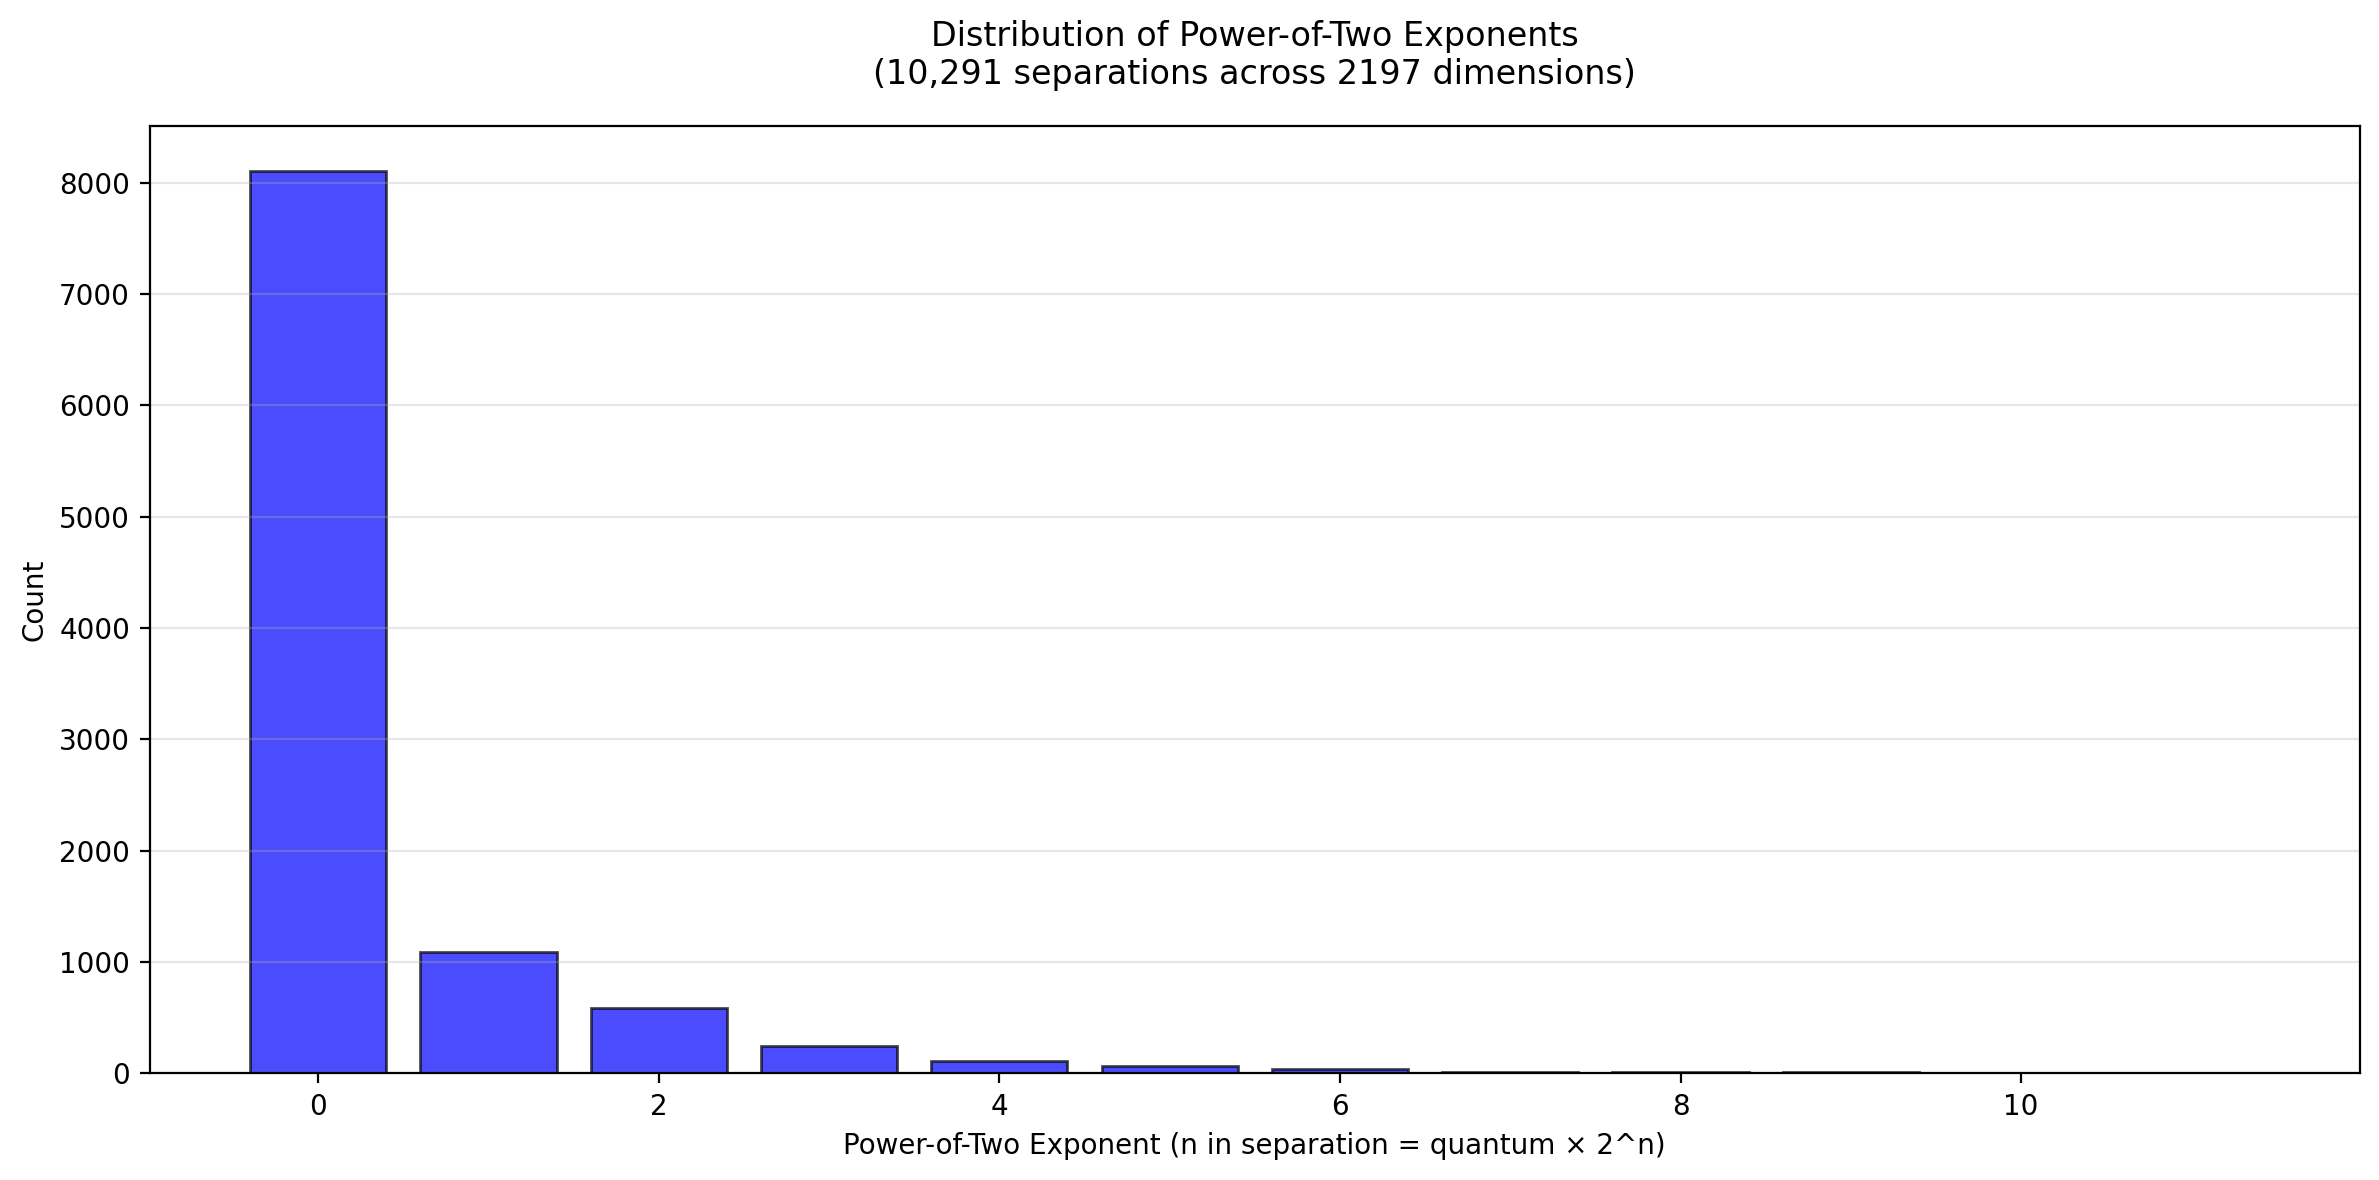


Most common exponents:
  2^0: 8,106 occurrences (78.77%)
  2^1: 1,093 occurrences (10.62%)
  2^2: 589 occurrences (5.72%)
  2^3: 246 occurrences (2.39%)
  2^4: 108 occurrences (1.05%)
  2^5: 69 occurrences (0.67%)
  2^6: 36 occurrences (0.35%)
  2^9: 15 occurrences (0.15%)
  2^7: 13 occurrences (0.13%)
  2^8: 12 occurrences (0.12%)


In [77]:
# Collect all exponents across all dimensions
all_exponents = []
for stats in dimension_stats:
    all_exponents.extend(stats['exponents'])

all_exponents = np.array(all_exponents)

# Count occurrences
unique_exp, counts = np.unique(all_exponents, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.bar(unique_exp, counts, color='blue', alpha=0.7, edgecolor='black')

ax.set_xlabel('Power-of-Two Exponent (n in separation = quantum × 2^n)', color='black')
ax.set_ylabel('Count', color='black')
ax.set_title(f'Distribution of Power-of-Two Exponents\n'
             f'({len(all_exponents):,} separations across {len(dimension_stats)} dimensions)',
             color='black', pad=15)
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'\nMost common exponents:')
top_indices = np.argsort(counts)[::-1][:10]
for idx in top_indices:
    exp = unique_exp[idx]
    count = counts[idx]
    print(f'  2^{exp}: {count:,} occurrences ({100*count/len(all_exponents):.2f}%)')

## Verify: Are Quanta Themselves Powers of Two?

In [78]:
# Collect all fundamental quanta
all_quanta = np.array([s['quantum'] for s in dimension_stats])

# Find global minimum quantum
global_quantum = all_quanta.min()

print(f'Global minimum quantum: {global_quantum:.6e}')
print()

# Check if all quanta are power-of-2 multiples of global quantum
quantum_pow2_results = []
quantum_exponents = []

for q in all_quanta:
    is_pow2, n, err = is_power_of_two_multiple(q, global_quantum, POWER_OF_TWO_TOLERANCE)
    quantum_pow2_results.append(is_pow2)
    quantum_exponents.append(n)

n_perfect_quanta = sum(quantum_pow2_results)
n_total_quanta = len(all_quanta)

print('Dimensional quanta that are power-of-2 multiples of global quantum:')
print(f'  {n_perfect_quanta} / {n_total_quanta} ({100*n_perfect_quanta/n_total_quanta:.2f}%)')
print()

if n_perfect_quanta == n_total_quanta:
    print('✓ All dimensional quanta are power-of-2 multiples of global quantum')
    print('  The entire structure is recursively power-of-2 quantized!')
    
    # Show distribution
    unique_qexp, qexp_counts = np.unique(quantum_exponents, return_counts=True)
    print('\nQuantum exponents:')
    for exp, count in zip(unique_qexp, qexp_counts):
        print(f'  2^{exp} × {global_quantum:.6e}: {count} dimensions')
else:
    print(f'⚠ {n_total_quanta - n_perfect_quanta} dimensions have non-power-of-2 quanta')

Global minimum quantum: 3.725290e-09

Dimensional quanta that are power-of-2 multiples of global quantum:
  2196 / 2197 (99.95%)

⚠ 1 dimensions have non-power-of-2 quanta


## Conclusion

In [79]:
print('='*70)
print('CONCLUSION')
print('='*70)

if n_perfect_dims == n_total_dims and n_perfect_quanta == n_total_quanta:
    print('\n✓ POWER-OF-TWO QUANTIZATION CONFIRMED')
    print('\n1. Every separation within each dimension is quantum × 2^n')
    print('2. Every dimensional quantum is global_quantum × 2^m')
    print('3. Therefore: all separations are power-of-two multiples of one base quantum')
    print('\nThis is CONCLUSIVE PROOF that these vectors live on the bfloat16 lattice.')
    print('\nThe fractional ULP ratios in 1.11f were artifacts of measuring with')
    print('the wrong ruler (ULP at val1 instead of the fundamental quantum).')
    print('\nWhen measured correctly, everything is exact integer powers of 2.')
    print('\nThese are discrete quantum states, not continuous floating-point values.')
elif n_perfect_dims == n_total_dims:
    print('\n✓ SEPARATIONS CONFIRMED: All separations within dimensions are power-of-2')
    print(f'⚠ QUANTA: {n_total_quanta - n_perfect_quanta} dimensions have non-power-of-2 quanta')
    print('\nThis still proves bfloat16 quantization within dimensions.')
else:
    print(f'\n⚠ INCOMPLETE: {n_total_dims - n_perfect_dims} dimensions show non-power-of-2 structure')
    print('Further investigation needed.')

print('\n' + '='*70)

CONCLUSION

⚠ INCOMPLETE: 210 dimensions show non-power-of-2 structure
Further investigation needed.

